In [32]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [34]:
# 파일들이 있는 폴더 경로
folder_path = 'C:/Users/mumu1/Desktop/project_movie_data/project_dataset'

# 파일 이름을 변수에 할당
o_df_customers = pd.read_csv(os.path.join(folder_path, 'olist_customers_dataset.csv'), encoding='ISO-8859-1')
o_df_geolocation = pd.read_csv(os.path.join(folder_path, 'olist_geolocation_dataset.csv'), encoding='ISO-8859-1')
o_df_order_items = pd.read_csv(os.path.join(folder_path, 'olist_order_items_dataset.csv'), encoding='ISO-8859-1')
o_df_order_payments = pd.read_csv(os.path.join(folder_path, 'olist_order_payments_dataset.csv'), encoding='ISO-8859-1')
o_df_order_reviews = pd.read_csv(os.path.join(folder_path, 'olist_order_reviews_dataset.csv'), encoding='ISO-8859-1')
o_df_products = pd.read_csv(os.path.join(folder_path, 'olist_products_dataset.csv'), encoding='ISO-8859-1')
o_df_sellers = pd.read_csv(os.path.join(folder_path, 'olist_sellers_dataset.csv'), encoding='ISO-8859-1')
o_df_product_category_name_translation = pd.read_csv(os.path.join(folder_path, 'product_category_name_translation.csv'), encoding='utf-8-sig')
o_df_orders = pd.read_csv(os.path.join(folder_path, 'olist_orders_dataset.csv'), encoding='ISO-8859-1')

print("✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.")

# 카피본 생성
df_customers = o_df_customers.copy()
df_geolocation = o_df_geolocation.copy()
df_order_items = o_df_order_items.copy()
df_order_payments = o_df_order_payments.copy()
df_order_reviews = o_df_order_reviews.copy()
df_products = o_df_products.copy()
df_sellers = o_df_sellers.copy()
df_product_category_name_translation = o_df_product_category_name_translation.copy()
df_order = o_df_orders.copy()

✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.


In [35]:
# 이상치 탐색
dfs = {
    "customers": df_customers,
    "geolocation": df_geolocation,
    "order_items": df_order_items,
    "order_payments": df_order_payments,
    "order_reviews": df_order_reviews,
    "orders": df_order,
    "products": df_products,
    "sellers": df_sellers,
    "product_category": df_product_category_name_translation
}

# 0, 음수 비율 + IQR 이상치 탐색 함수
def check_data_quality(df, name):
    print(f"\n===== {name} =====")
    num_cols = df.select_dtypes(include="number").columns
    if len(num_cols) == 0:
        print("수치형 컬럼 없음")
        return
    for col in num_cols:
        total = len(df)

        # 0 / 음수 비율
        zero_ratio = (df[col] == 0).sum() / total * 100
        neg_ratio = (df[col] < 0).sum() / total * 100

        # IQR 이상치 비율
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outlier_ratio = ((df[col] < lower) | (df[col] > upper)).sum() / total * 100

        # 출력
        if zero_ratio > 0 or neg_ratio > 0 or outlier_ratio > 0:
            print(f"- {col}: 0 비율={zero_ratio:.2f}%, 음수 비율={neg_ratio:.2f}%, 이상치 비율={outlier_ratio:.2f}%")

# 실행
for name, df in dfs.items():
    check_data_quality(df, name)



===== customers =====

===== geolocation =====
- geolocation_lat: 0 비율=0.00%, 음수 비율=99.87%, 이상치 비율=16.82%
- geolocation_lng: 0 비율=0.00%, 음수 비율=100.00%, 이상치 비율=4.23%

===== order_items =====
- order_item_id: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=12.41%
- price: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=7.48%
- freight_value: 0 비율=0.34%, 음수 비율=0.00%, 이상치 비율=10.77%

===== order_payments =====
- payment_sequential: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.36%
- payment_installments: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.08%
- payment_value: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=7.68%

===== order_reviews =====
- review_score: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=14.69%

===== orders =====
수치형 컬럼 없음

===== products =====
- product_name_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=0.88%
- product_description_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.31%
- product_photos_qty: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=2.58%
- product_weight_g: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=13.81%
- product_length_cm: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.19%
- pr

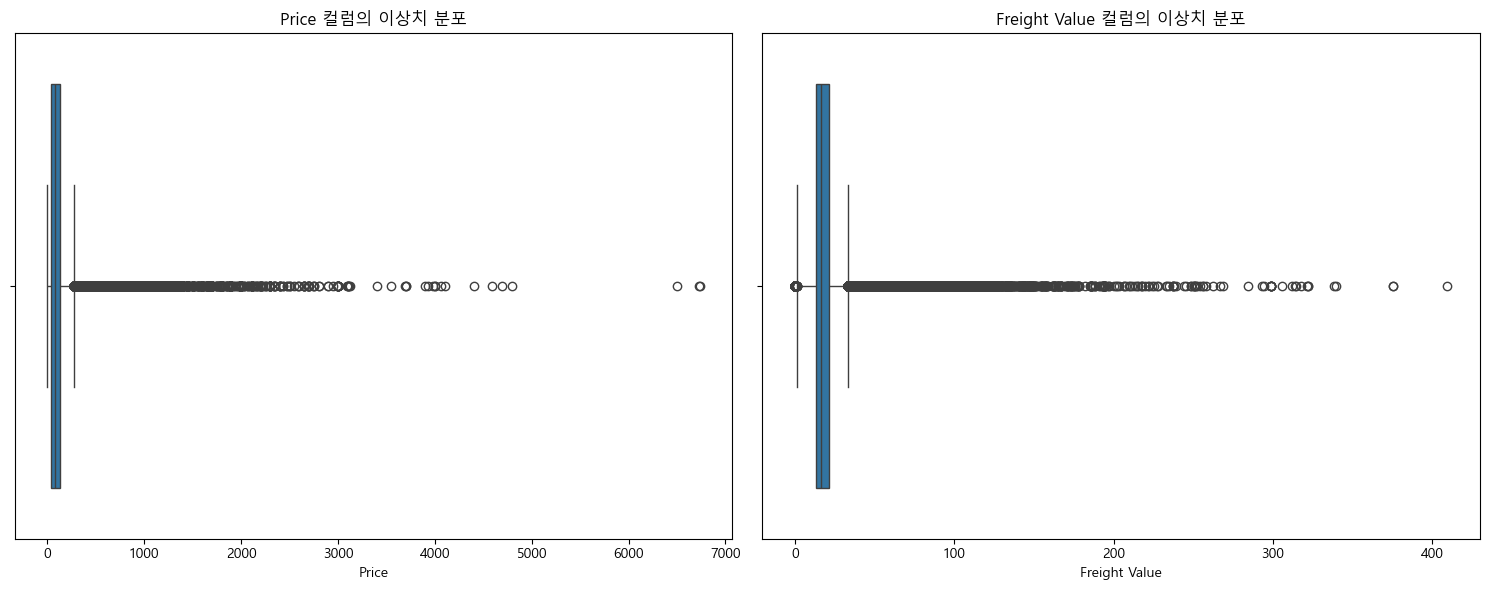

In [36]:
# 이상치 확인: order_item['price'],['fight_value]: 시각화
# 고가의 구매제품 존재, 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. price 컬럼
sns.boxplot(x=df_order_items['price'], ax=axes[0])
axes[0].set_title('Price 컬럼의 이상치 분포')
axes[0].set_xlabel('Price')

# 2. freight_value 컬럼의 상자 그림
sns.boxplot(x=df_order_items['freight_value'], ax=axes[1])
axes[1].set_title('Freight Value 컬럼의 이상치 분포')
axes[1].set_xlabel('Freight Value')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

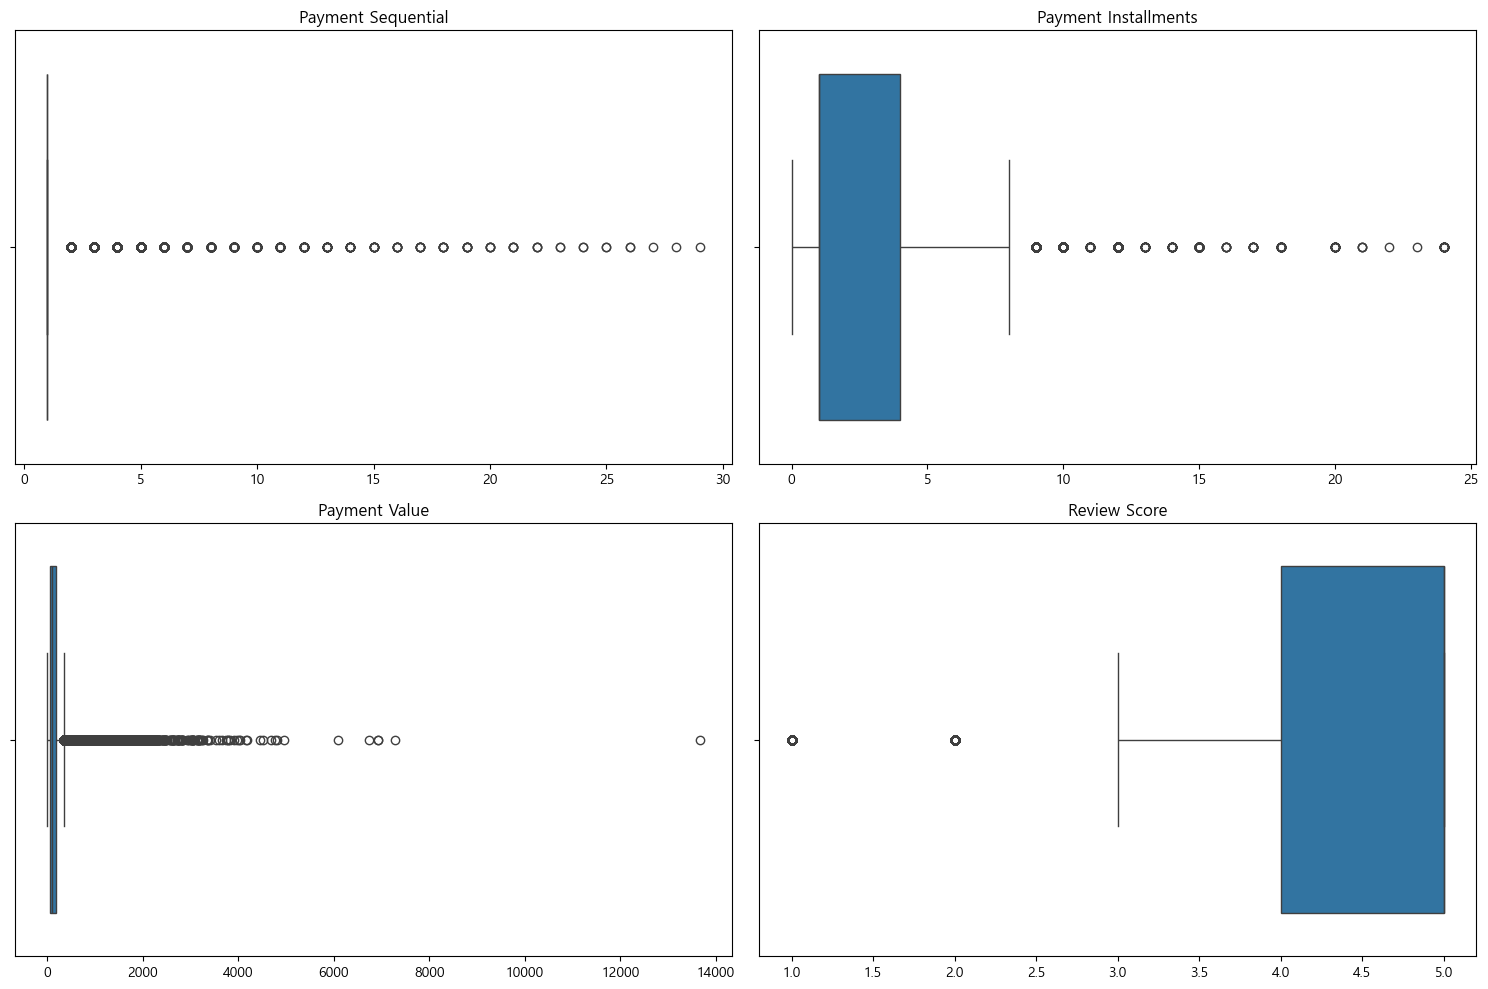

In [37]:
# 이상치 시각화: 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. payment_sequential
sns.boxplot(x=df_order_payments['payment_sequential'], ax=axes[0, 0])
axes[0, 0].set_title('Payment Sequential')
axes[0, 0].set_xlabel('')

# 2. payment_installments
sns.boxplot(x=df_order_payments['payment_installments'], ax=axes[0, 1])
axes[0, 1].set_title('Payment Installments')
axes[0, 1].set_xlabel('')

# 3. payment_value
sns.boxplot(x=df_order_payments['payment_value'], ax=axes[1, 0])
axes[1, 0].set_title('Payment Value')
axes[1, 0].set_xlabel('')

# 4. review_score
sns.boxplot(x=df_order_reviews['review_score'], ax=axes[1, 1])
axes[1, 1].set_title('Review Score')
axes[1, 1].set_xlabel('')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [38]:
# payment_sequential 이상치 확인

# payment_sequential = 29 인 주문 찾기
# seq_29_orders = df_order_payments[df_order_payments['payment_sequential'] == 29]['order_id'].unique()
# print("payment_sequential=29 주문 수:", len(seq_29_orders))

# 해당 주문 상세 결제 내역 확인
# df_seq_29 = df_order_payments[df_order_payments['order_id'].isin(seq_29_orders)]
# df_seq_29 = df_seq_29.sort_values(['order_id','payment_sequential'])
# print(df_seq_29.head(20))

# 1) payment_sequential ≥ 10인 주문 ID 추출
hi_seq_orders = (
    df_order_payments.loc[df_order_payments["payment_sequential"] >= 10, "order_id"]
    .unique()
)

# 2) 해당 주문들의 결제 상세 내역 추출
hi_seq_details = (
    df_order_payments[df_order_payments["order_id"].isin(hi_seq_orders)]
    .copy()
)

# 3) 결제ID 단위 그룹핑 (order_id + payment_sequential)
grouped_by_payment = (
    hi_seq_details
    .groupby(["order_id", "payment_sequential"], as_index=False)
    .agg(
        payment_type=("payment_type", "first"),
        installments=("payment_installments", "first"),
        value_sum=("payment_value", "sum"),
        record_count=("payment_value", "count")
    )
    .sort_values(["order_id", "payment_sequential"])
)

print("=== 결제ID 단위 그룹핑 (상위 20행) ===")
print(grouped_by_payment.head(20))

# 4) 주문 단위 요약 (결제 건수, 합계)
summary_by_order = (
    grouped_by_payment
    .groupby("order_id", as_index=False)
    .agg(
        payments_cnt=("payment_sequential", "max"),
        payment_sum=("value_sum", "sum")
    )
    .sort_values("payments_cnt", ascending=False)
)

print("\n=== 주문 단위 요약 (Top 10) ===")
print(summary_by_order.head(10))

=== 결제ID 단위 그룹핑 (상위 20행) ===
                            order_id  payment_sequential payment_type  \
0   0bbb3f7791a87d0307555e57da3a1ff1                   1  credit_card   
1   0bbb3f7791a87d0307555e57da3a1ff1                   2      voucher   
2   0bbb3f7791a87d0307555e57da3a1ff1                   3      voucher   
3   0bbb3f7791a87d0307555e57da3a1ff1                   4      voucher   
4   0bbb3f7791a87d0307555e57da3a1ff1                   5      voucher   
5   0bbb3f7791a87d0307555e57da3a1ff1                   6      voucher   
6   0bbb3f7791a87d0307555e57da3a1ff1                   7      voucher   
7   0bbb3f7791a87d0307555e57da3a1ff1                   8      voucher   
8   0bbb3f7791a87d0307555e57da3a1ff1                   9      voucher   
9   0bbb3f7791a87d0307555e57da3a1ff1                  10      voucher   
10  0bbb3f7791a87d0307555e57da3a1ff1                  11      voucher   
11  1a611328643ae11146ba09a4425d2e12                   1  credit_card   
12  1a611328643ae11146

In [39]:
# 8개 데이터프레임의 결측값 분석
def check_missing(dfs, df_names):
    for df, name in zip(dfs, df_names):
        print(f"\n📊 {name} 데이터프레임 결측값 분석")
        
        missing_info = df.isnull().sum()
        m_pct = (missing_info / len(df)) * 100
        
        if missing_info.sum() == 0:
            print("✅ 결측값 없음. 완전")
        else:
            print("⚠️ 결측치 존재")
            missing_sum = pd.DataFrame({
                '결측수': missing_info,
                '결측율(%)': m_pct,
            }).round(2)
            missing_sum = missing_sum[missing_sum['결측수'] > 0]
            display(missing_sum)

# 사용 예시
original_dfs = [ 
    o_df_customers, o_df_geolocation, o_df_order_items,
    o_df_order_payments, o_df_order_reviews, o_df_products,
    o_df_sellers, o_df_product_category_name_translation,
]

df_names = [
    "customers", "geolocation", "order_items",
    "order_payments", "order_reviews", "products",
    "sellers", "product_category_name_translation",
]

check_missing(original_dfs, df_names)


📊 customers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 geolocation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_items 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_payments 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_reviews 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70



📊 products 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01



📊 sellers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 product_category_name_translation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전


# 전처리

In [40]:
# df_products #32951

# 결측치 보존: 2448
# 이상치: 음수 없음, '0' 보존
# 마이너스 값 없음

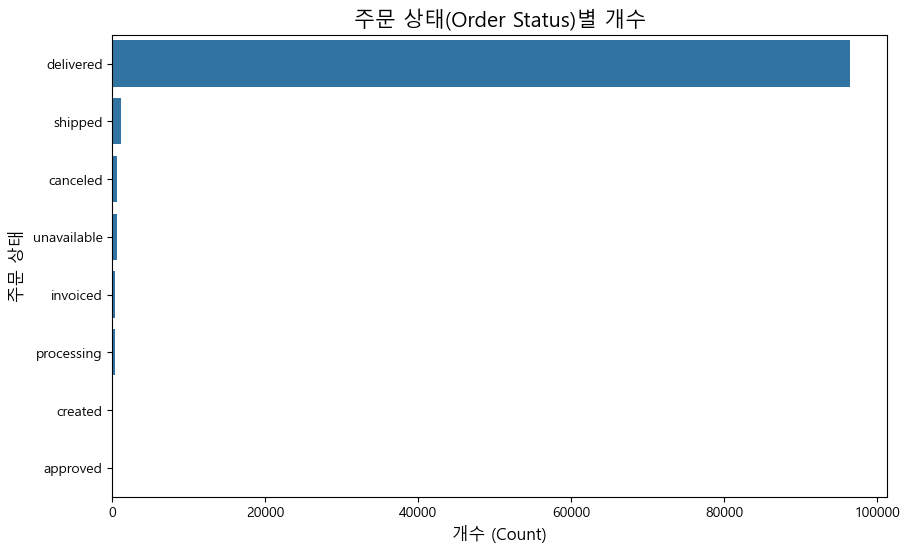

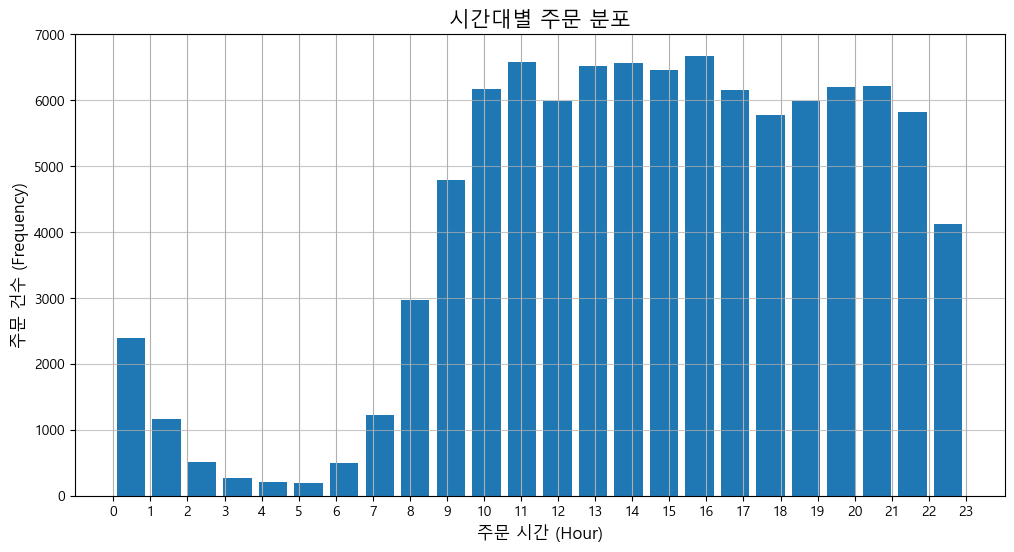

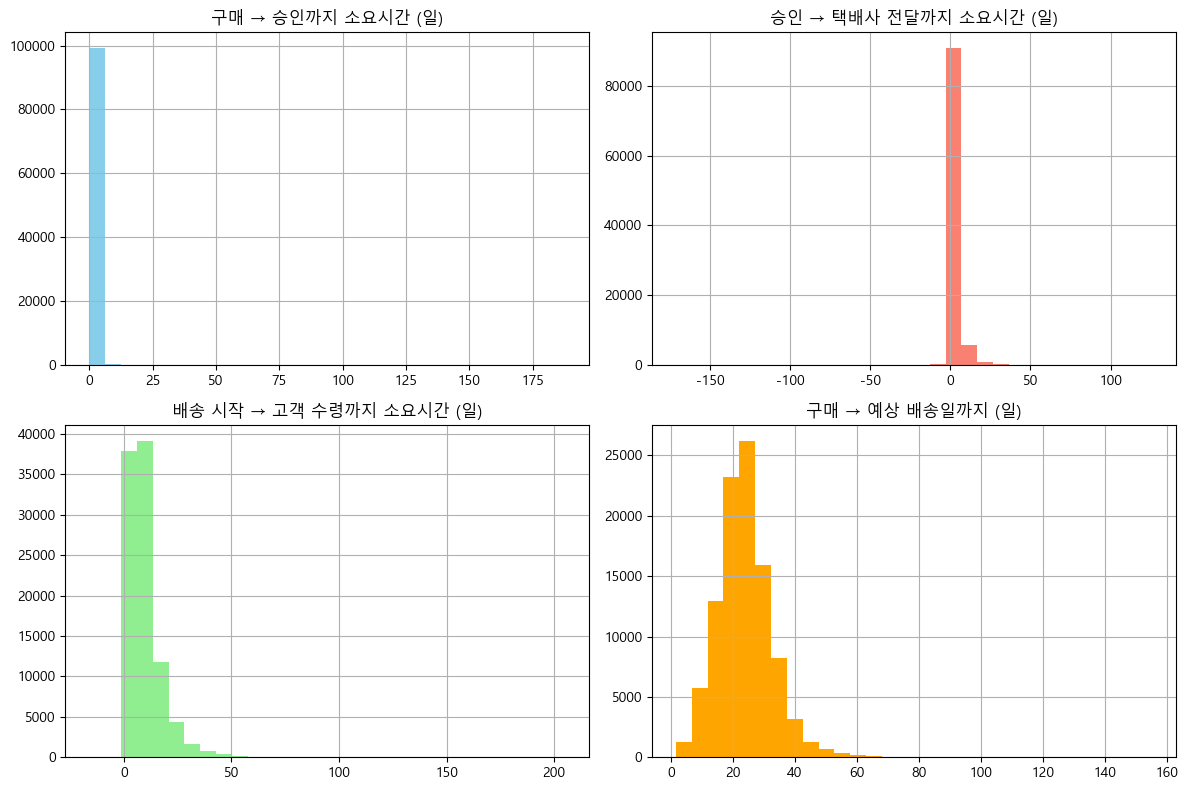

In [41]:
# EDA  df_order

# order_status 컬럼의 각 값의 개수를 막대 그래프.
plt.figure(figsize=(10, 6))
sns.countplot(data=df_order, y='order_status', order=df_order['order_status'].value_counts().index)
plt.title('주문 상태(Order Status)별 개수', fontsize=15)
plt.xlabel('개수 (Count)', fontsize=12)
plt.ylabel('주문 상태', fontsize=12)
plt.show()

# 1. 날짜/시간 관련 컬럼들을 datetime 타입으로 변환
# errors='coerce'는 변환 중 오류 발생 시 해당 값을 NaT(Not a Time)으로 처리
time_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in time_cols:
    df_order[col] = pd.to_datetime(df_order[col], errors='coerce')

# 2. '주문 시간(hour)'을 추출하여 히스토그램
plt.figure(figsize=(12, 6))
df_order['order_purchase_timestamp'].dt.hour.hist(bins=24, rwidth=0.8) # 24시간을 기준으로
plt.title('시간대별 주문 분포', fontsize=15)
plt.xlabel('주문 시간 (Hour)', fontsize=12)
plt.ylabel('주문 건수 (Frequency)', fontsize=12)
plt.xticks(range(0, 24)) # x축 눈금을 0부터 23까지 표시
plt.grid(axis='y', alpha=0.7)
plt.show()

# 날짜 차이 계산 (일 단위)
df_order['purchase_to_approved'] = (df_order['order_approved_at'] - df_order['order_purchase_timestamp']).dt.total_seconds() / 86400
df_order['approved_to_carrier'] = (df_order['order_delivered_carrier_date'] - df_order['order_approved_at']).dt.total_seconds() / 86400
df_order['carrier_to_customer'] = (df_order['order_delivered_customer_date'] - df_order['order_delivered_carrier_date']).dt.total_seconds() / 86400
df_order['purchase_to_estimated'] = (df_order['order_estimated_delivery_date'] - df_order['order_purchase_timestamp']).dt.total_seconds() / 86400

# 시각화 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_order['purchase_to_approved'].hist(bins=30, ax=axes[0,0], color='skyblue')
axes[0,0].set_title('구매 → 승인까지 소요시간 (일)')

df_order['approved_to_carrier'].hist(bins=30, ax=axes[0,1], color='salmon')
axes[0,1].set_title('승인 → 택배사 전달까지 소요시간 (일)')

df_order['carrier_to_customer'].hist(bins=30, ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('배송 시작 → 고객 수령까지 소요시간 (일)')

df_order['purchase_to_estimated'].hist(bins=30, ax=axes[1,1], color='orange')
axes[1,1].set_title('구매 → 예상 배송일까지 (일)')

plt.tight_layout()
plt.show()

In [42]:
# df_orders 이상치 확인 및 삭제 처리, 컬럼 추가

# 1. approved → carrier 음수
df_order['time_approved_to_carrier'] = (
    pd.to_datetime(df_order['order_delivered_carrier_date']) - 
    pd.to_datetime(df_order['order_approved_at'])
).dt.total_seconds() / 86400

negative_2 = (df_order['time_approved_to_carrier'] < 0).sum()
print(f"⚠️ approved → carrier 음수: {negative_2}건 <- 이상치 삭제 필요")

# 2. carrier → customer 음수
df_order['time_carrier_to_customer'] = (
    pd.to_datetime(df_order['order_delivered_customer_date']) - 
    pd.to_datetime(df_order['order_delivered_carrier_date'])
).dt.total_seconds() / 86400

negative_3 = (df_order['time_carrier_to_customer'] < 0).sum()
print(f"⚠️ carrier → customer 음수: {negative_3}건 <- 이상치 삭제 필요")

# 3. 이상치 제거
df_order = df_order[
    (df_order['time_approved_to_carrier'] >= 0) &
    (df_order['time_carrier_to_customer'] >= 0)
]

print(f"\n✅ 이상치 제거 후 행 수: {len(df_order)}")

# 배달 완료 데이터 기준, 배달이 정시에 도착했는지 확인용 컬럼 on_time 추가
# 배달 완료된 주문만 필터링
df_delivered = df_order[df_order['order_status'] == 'delivered'].copy()

# delay_days 계산 (실제 - 예상)
df_delivered['delay_days'] = (
    pd.to_datetime(df_delivered['order_delivered_customer_date']) - 
    pd.to_datetime(df_delivered['order_estimated_delivery_date'])
).dt.total_seconds() / 86400

# on_time 컬럼 추가
df_delivered['on_time'] = df_delivered['delay_days'] <= 0

# 결과 확인
print("배달 완료 건수:", len(df_delivered))
print("\n배송 성과:")
print(df_delivered['on_time'].value_counts())
print(f"\n정시 배송률: {df_delivered['on_time'].mean():.2%}")
print(f"평균 지연일: {df_delivered['delay_days'].mean():.1f}일")

⚠️ approved → carrier 음수: 1359건 <- 이상치 삭제 필요
⚠️ carrier → customer 음수: 23건 <- 이상치 삭제 필요

✅ 이상치 제거 후 행 수: 95088
배달 완료 건수: 95082

배송 성과:
on_time
True     87290
False     7792
Name: count, dtype: int64

정시 배송률: 91.80%
평균 지연일: -11.1일


In [43]:
# 이상치 탐지 
df_order_items.describe() # 음수 없음

# 0값 탐지
df_combined_outliers = df_order_items[(df_order_items['price'] == 0) | (df_order_items['freight_value'] == 0)]
print(len(df_combined_outliers))

# 결측률 확인
zero_rate = (df_order_items[['price','freight_value']] == 0).mean()
print(zero_rate)

383
price            0.0000
freight_value    0.0034
dtype: float64


📌 피어슨 상관계수:
                   price  freight_value
price          1.000000       0.414204
freight_value  0.414204       1.000000

📌 스피어맨 상관계수:
                  price  freight_value
price          1.00000        0.43419
freight_value  0.43419        1.00000


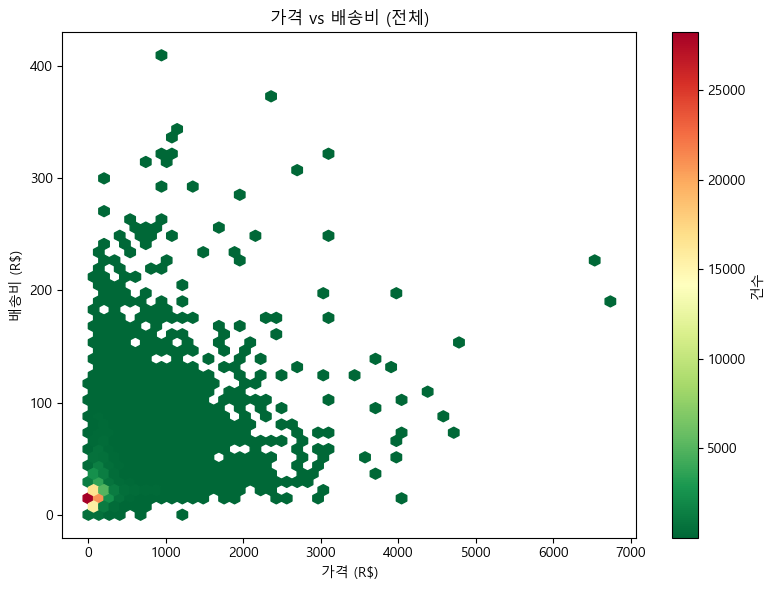

전체 데이터 행 수: 112650
IsolationForest 모델이 탐지한 이상치 개수: 1127
이상치 비율: 1.0004438526409232 %


In [44]:
# df_order_items 가격과 배송료 상관관계

# 1) 기본 상관관계 확인
corr_pearson = df_order_items[['price','freight_value']].corr(method='pearson')
corr_spearman = df_order_items[['price','freight_value']].corr(method='spearman')

print("📌 피어슨 상관계수:\n", corr_pearson)
print("\n📌 스피어맨 상관계수:\n", corr_spearman)

# 2) 시각화
plt.figure(figsize=(8, 6))
hb = plt.hexbin(df_order_items['price'], df_order_items['freight_value'], 
                gridsize=50, cmap='RdYlGn_r', mincnt=1)
plt.title('가격 vs 배송비 (전체)')
plt.xlabel('가격 (R$)')
plt.ylabel('배송비 (R$)')
plt.colorbar(hb, label='건수')
plt.tight_layout()
plt.show()

# 3) IsolationForest로 이상치 탐지
iso = IsolationForest(contamination=0.01, random_state=42)
df_order_items['outlier'] = iso.fit_predict(df_order_items[['price','freight_value']])

# 예측 결과를 'outlier_preds'라는 별도 변수에 저장
outlier_preds = iso.fit_predict(df_order_items[['price','freight_value']])

# 저장된 변수를 사용해 이상치 정보를 출력
print("전체 데이터 행 수:", len(df_order_items))
print("IsolationForest 모델이 탐지한 이상치 개수:", (outlier_preds == -1).sum())
print("이상치 비율:", (outlier_preds == -1).mean()*100, "%")


In [45]:
'''
df_order_items 컬럼 추가(기준: 결제완료 건)
'item_total' id별 
'freight_total': id별 
'order_total' : id별, 'item_total' + 'freight_total'
'order_total' : 전체 총 매출
'''

# 배송비가 있는 (결제 완료된) 주문만 필터링
df_order_items = df_order_items[df_order_items['freight_value'] > 0]

# order_id별 집계
df_order_items['item_count'] = df_order_items.groupby('order_id')['order_item_id'].transform('count')
df_order_items['item_total'] = df_order_items.groupby('order_id')['price'].transform('sum')
df_order_items['freight_total'] = df_order_items.groupby('order_id')['freight_value'].transform('sum')
df_order_items['order_total'] = df_order_items['item_total'] + df_order_items['freight_total']

df_order_items.info()

C:\Users\mumu1\AppData\Local\Temp\ipykernel_33172\2237012270.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items['item_count'] = df_order_items.groupby('order_id')['order_item_id'].transform('count')
C:\Users\mumu1\AppData\Local\Temp\ipykernel_33172\2237012270.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items['item_total'] = df_order_items.groupby('order_id')['price'].transform('sum')


<class 'pandas.core.frame.DataFrame'>
Index: 112267 entries, 0 to 112649
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112267 non-null  object 
 1   order_item_id        112267 non-null  int64  
 2   product_id           112267 non-null  object 
 3   seller_id            112267 non-null  object 
 4   shipping_limit_date  112267 non-null  object 
 5   price                112267 non-null  float64
 6   freight_value        112267 non-null  float64
 7   outlier              112267 non-null  int64  
 8   item_count           112267 non-null  int64  
 9   item_total           112267 non-null  float64
 10  freight_total        112267 non-null  float64
 11  order_total          112267 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 11.1+ MB


C:\Users\mumu1\AppData\Local\Temp\ipykernel_33172\2237012270.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items['freight_total'] = df_order_items.groupby('order_id')['freight_value'].transform('sum')
C:\Users\mumu1\AppData\Local\Temp\ipykernel_33172\2237012270.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order_items['order_total'] = df_order_items['item_total'] + df_order_items['freight_total']


In [46]:
'''
df_order_reviews 전처리

- 전처리 전 
review_comment_title: 결측치 88% → 고객 대부분이 제목은 아예 작성하지 않음.
review_comment_message: 결측치 59% → 절반 이상이 코멘트를 남기지 않음.
review_score → 전부 존재
- 전처리 후
타이틀 작성, 코멘트 작성 컬럼 추가
'''
# 목적: 배송 지연 ↔ 리뷰 점수, 텍스트 작성 여부 분석

# 1. 플래그 추가
df_order_reviews['has_title'] = df_order_reviews['review_comment_title'].notna()
df_order_reviews['has_comment'] = df_order_reviews['review_comment_message'].notna()

# 2. 현황 확인
print("✅ 전처리 완료")
print(f"전체 리뷰: {len(df_order_reviews):,}개")
print(f"제목 있음: {df_order_reviews['has_title'].sum():,}개 ({df_order_reviews['has_title'].mean()*100:.1f}%)")
print(f"코멘트 있음: {df_order_reviews['has_comment'].sum():,}개 ({df_order_reviews['has_comment'].mean()*100:.1f}%)")

✅ 전처리 완료
전체 리뷰: 99,224개
제목 있음: 11,568개 (11.7%)
코멘트 있음: 40,977개 (41.3%)


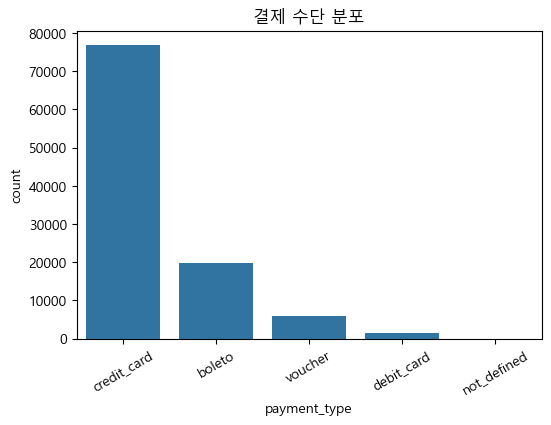


[결제 수단 비율]
payment_type
credit_card    0.739
boleto         0.190
voucher        0.056
debit_card     0.015
not_defined    0.000
Name: proportion, dtype: float64


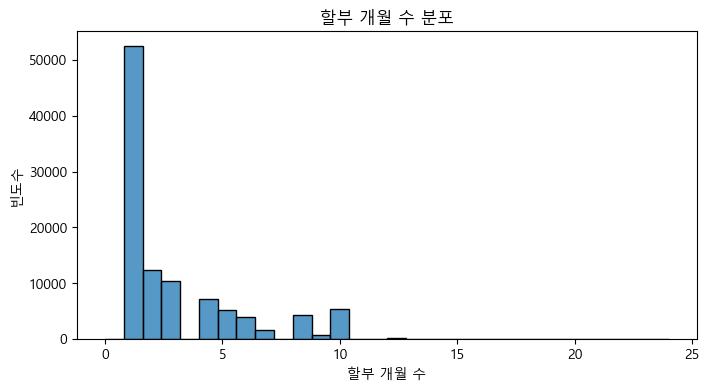


[할부 개월 수 통계]
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


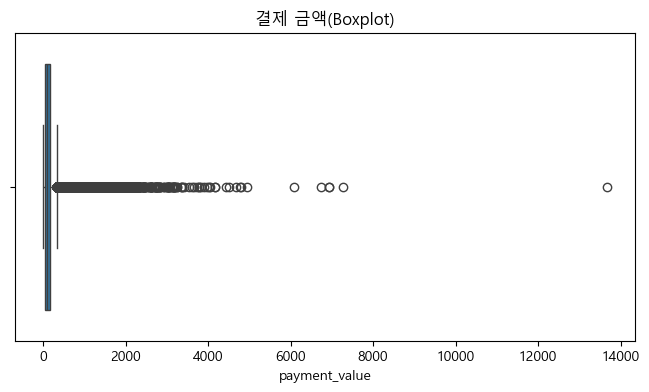

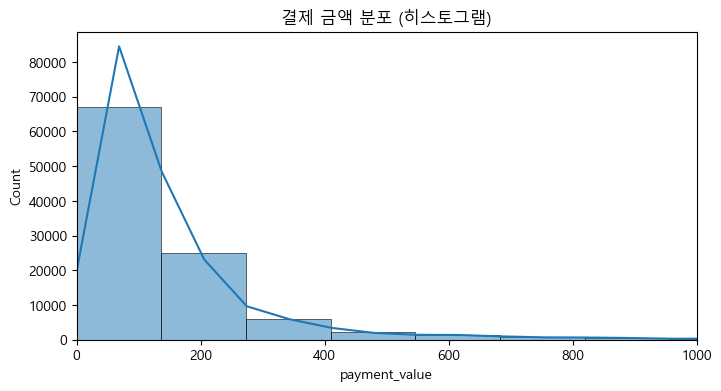


[결제 금액 통계]
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64
결제금액 0원 비율: 0.01%


In [47]:
# df_order_payments: 결측X, 이상치 탐지

# 1. payment_type 분포 확인
plt.figure(figsize=(6,4))
sns.countplot(data=o_df_order_payments, x='payment_type', order=o_df_order_payments['payment_type'].value_counts().index)
plt.title("결제 수단 분포")
plt.xticks(rotation=30)
plt.show()

print("\n[결제 수단 비율]")
print(o_df_order_payments['payment_type'].value_counts(normalize=True).round(3))

# 2. 할부 개월 수 분포
plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_installments'], bins=30, kde=False)
plt.title("할부 개월 수 분포")
plt.xlabel("할부 개월 수")
plt.ylabel("빈도수")
plt.show()

print("\n[할부 개월 수 통계]")
print(o_df_order_payments['payment_installments'].describe())

# 3. 결제 금액 분포 (payment_value)
plt.figure(figsize=(8,4))
sns.boxplot(x=o_df_order_payments['payment_value'])
plt.title("결제 금액(Boxplot)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_value'], bins=100, kde=True)
plt.title("결제 금액 분포 (히스토그램)")
plt.xlim(0, 1000)  # 고액 결제는 따로 확인하기 위해 일단 1000 이하만 시각화
plt.show()

print("\n[결제 금액 통계]")
print(o_df_order_payments['payment_value'].describe())

# 결제금액 0달러 비율: 0.01%
zero_payment_ratio = (df_order_payments['payment_value'] == 0).mean()
print(f"결제금액 0원 비율: {zero_payment_ratio:.2%}")

# 결제금액 == 0 and 결제방법 확인
df_order_payments[df_order_payments['payment_value'] == 0]['payment_type'].value_counts()

# 이상치 처리: 결제금액 == 0 and 결제방법=not dine 3건 삭제
df_order_payments = df_order_payments[df_order_payments['payment_type'] != 'not_defined']


# merge

In [48]:
# 1) merge: df_order + df_order_items = merge_order_items
# 결측치 삭제 처리: df_order에는 있지만 df_order_items에는 없는 주문 (1,113건) 1%
# 결측치: 취소/미완료/불가능/데이터 오류 데이터

# 1:m로 병합
df_order_items_merged = df_order.merge(
    df_order_items,
    how="left",          
    on="order_id",
    validate="1:m"       )

# 병합 결과 점검
print("✅ Shapes (order, items, merged):", df_order.shape, df_order_items.shape, df_order_items_merged.shape)
print("✅ 주문 건수 유지 여부:",
      df_order['order_id'].nunique(), "→",
      df_order_items_merged['order_id'].nunique())

# 머지 후 결측치 대략 확인 (아이템 없는 주문이 있는지 등)
null_summary = df_order_items_merged.isna().sum().sort_values(ascending=False).head(10)
print("\n🔎 결측치 Top10 컬럼\n", null_summary)

# 1) 아이템 정보가 없는 주문 식별
mask_no_items = df_order_items_merged['order_item_id'].isna()
no_item_orders = df_order_items_merged.loc[mask_no_items, ['order_id', 'order_status']].drop_duplicates()

print("아이템 없는 주문 수(고유 order_id):", no_item_orders['order_id'].nunique())

# 2) 주문 상태 분포 (건수)
status_counts = no_item_orders['order_status'].value_counts(dropna=False)
print("\n[아이템 없는 주문의 order_status 분포 - 건수]\n", status_counts)

# 3) 주문 상태 분포 (비율)
status_ratio = no_item_orders['order_status'].value_counts(normalize=True, dropna=False).mul(100).round(2)
print("\n[아이템 없는 주문의 order_status 분포 - 비율(%)]\n", status_ratio)

## 결측치 삭제: 아이템이 없는 1,113건은 대부분 분석에서 제외
# unavailable, canceled → 제외 (아이템이 없으므로 Monetary 계산 불가)
# delivered인데 아이템 없는 336건 → 데이터 품질 이슈, 제외
# created, shipped, invoiced → 건수 적고 불완전, 제외

# 1) 아이템 있는 주문만 필터링
merge_order_items = df_order_items_merged[~df_order_items_merged['order_item_id'].isna()].copy()

# 2) 확인
print("✅ 필터링 후 행 수:", merge_order_items.shape)
print("✅ 고유 주문 수:", merge_order_items['order_id'].nunique())

# 3) order_status 분포 재확인 (정상 주문만)
print("\n[정상 주문의 order_status 분포]")
print(merge_order_items['order_status'].value_counts(normalize=True).mul(100).round(2).head())

# 4) sanity check: 아이템 없는 주문 수가 잘 제거됐는지
removed_orders = set(df_order_items_merged['order_id']) - set(merge_order_items['order_id'])
print("\n제거된 주문 수:", len(removed_orders))



✅ Shapes (order, items, merged): (95088, 14) (112267, 12) (108543, 25)
✅ 주문 건수 유지 여부: 95088 → 95088

🔎 결측치 Top10 컬럼
 freight_total          325
shipping_limit_date    325
price                  325
freight_value          325
outlier                325
item_count             325
order_item_id          325
seller_id              325
product_id             325
order_total            325
dtype: int64
아이템 없는 주문 수(고유 order_id): 325

[아이템 없는 주문의 order_status 분포 - 건수]
 order_status
delivered    325
Name: count, dtype: int64

[아이템 없는 주문의 order_status 분포 - 비율(%)]
 order_status
delivered    100.0
Name: proportion, dtype: float64
✅ 필터링 후 행 수: (108218, 25)
✅ 고유 주문 수: 94763

[정상 주문의 order_status 분포]
order_status
delivered    99.99
canceled      0.01
Name: proportion, dtype: float64

제거된 주문 수: 325


In [49]:
# 2) inner join 병합: merge_order_items + df_customers = merge_oic

# 0) 안전장치: 키/타입 점검
assert 'customer_id' in merge_order_items.columns, "merge_order_items에 customer_id가 없습니다."
assert 'customer_id' in df_customers.columns, "df_customers에 customer_id가 없습니다."

merge_order_items = merge_order_items.copy()
df_customers = df_customers.copy()

merge_order_items['customer_id'] = merge_order_items['customer_id'].astype(str)
df_customers['customer_id'] = df_customers['customer_id'].astype(str)

# 1) 고객 테이블에서 customer_id 중복 제거 (m:1 보장)
dup_cnt = df_customers['customer_id'].duplicated().sum()
if dup_cnt > 0:
    print(f"[알림] df_customers에 customer_id 중복 {dup_cnt}건 → 첫 번째만 사용")
df_customers_dedup = df_customers.drop_duplicates(subset='customer_id', keep='first')

# 2) 병합 (m:1 관계)
merge_oic = merge_order_items.merge(
    df_customers_dedup,
    how='left',                 # 주문–아이템은 유지, 고객정보 없으면 NaN
    on='customer_id',
    validate='m:1',             # many:one 관계 보장
    suffixes=('', '_cust')      # 혹시 중복 컬럼 있을 때 고객쪽 접미사
)

# 3) 결과 점검
print("✅ Shapes (order_items, customers, merged):",
      merge_order_items.shape, df_customers_dedup.shape, merge_oic.shape)

# 병합으로 행 수가 늘거나 줄지 확인 (m:1이면 행 수 동일해야 정상)
if merge_oic.shape[0] != merge_order_items.shape[0]:
    print("[주의] 병합 후 행 수가 달라졌습니다. 예상치와 다르면 키 중복/결측 여부를 확인하세요.")

# 고객 정보 매칭률 확인
missing_cust = merge_oic['customer_city'].isna().sum() if 'customer_city' in merge_oic.columns else None
if missing_cust is not None:
    total_rows = merge_oic.shape[0]
    print(f"🔎 고객 정보 결측 행 수: {missing_cust} ({missing_cust/total_rows*100:.2f}%)")

# 결측치 많은 고객 컬럼 Top5
cust_cols = [c for c in ['customer_unique_id','customer_zip_code_prefix','customer_city','customer_state'] if c in merge_oic.columns]
if cust_cols:
    print("\n[고객 컬럼 결측치]")
    print(merge_oic[cust_cols].isna().sum().sort_values(ascending=False))


✅ Shapes (order_items, customers, merged): (108218, 25) (99441, 5) (108218, 29)
🔎 고객 정보 결측 행 수: 0 (0.00%)

[고객 컬럼 결측치]
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


In [50]:
# 3) merge_oic + df_sellers = merge_oics

# 0) 안전장치: 키/타입 점검
assert 'seller_id' in merge_oic.columns, "merge_oic에 seller_id가 없습니다."
assert 'seller_id' in df_sellers.columns, "df_sellers에 seller_id가 없습니다."

merge_oic = merge_oic.copy()
df_sellers = df_sellers.copy()

merge_oic['seller_id'] = merge_oic['seller_id'].astype(str)
df_sellers['seller_id'] = df_sellers['seller_id'].astype(str)

# 1) 셀러 테이블에서 seller_id 중복 제거 (m:1 보장)
dup_cnt = df_sellers['seller_id'].duplicated().sum()
if dup_cnt > 0:
    print(f"[알림] df_sellers에 seller_id 중복 {dup_cnt}건 → 첫 번째만 사용")
df_sellers_dedup = df_sellers.drop_duplicates(subset='seller_id', keep='first')

# 2) 병합 (m:1)
merge_oics = merge_oic.merge(
    df_sellers_dedup,
    how='left',                  # 주문·아이템은 유지, 셀러 정보 없으면 NaN
    on='seller_id',
    validate='m:1',              # many:one 관계 확인
    suffixes=('', '_seller')     # 셀러 쪽 충돌 컬럼에 접미사
)

# 3) 결과 점검
print("✅ Shapes (oic, sellers, merged):",
      merge_oic.shape, df_sellers_dedup.shape, merge_oics.shape)


✅ Shapes (oic, sellers, merged): (108218, 29) (3095, 4) (108218, 32)


# 1: 고객 세분화 및 RFM 분석
브라질 지역별 고객들의 구매 패턴을 분석하여 RFM(Recency, Frequency, Monetary) 모델을 구축하고,
고객을 세분화하여 각 세그먼트의 특성과 비즈니스 전략을 제시

📊 고객 세그먼트별 분석
신규고객         | 고객:  57,115명 ( 60.3%) | 매출:      9,121,693원 ( 60.1%) | 평균:        160원
이탈위험         | 고객:  18,776명 ( 19.8%) | 매출:      3,056,670원 ( 20.1%) | 평균:        163원
휴면고객         | 고객:  18,872명 ( 19.9%) | 매출:      2,994,203원 ( 19.7%) | 평균:        159원

🌟 우수고객 매출 비율 확인
⚠️  우수고객 세그먼트가 없습니다.

[세그먼트별 RFM 점수 조합 (Top 5)]

신규고객:
R_score  F_score  M_score
4        1        4          4038
                  5          3927
5        1        4          3919
3        1        3          3903
                  4          3893
Name: count, dtype: int64
총 57,115명

이탈위험:
R_score  F_score  M_score
2        1        2          4090
                  5          3795
                  3          3729
                  4          3618
                  1          3544
Name: count, dtype: int64
총 18,776명

휴면고객:
R_score  F_score  M_score
1        1        1          3963
                  2          3945
                  5          3765
                  3          3716
                

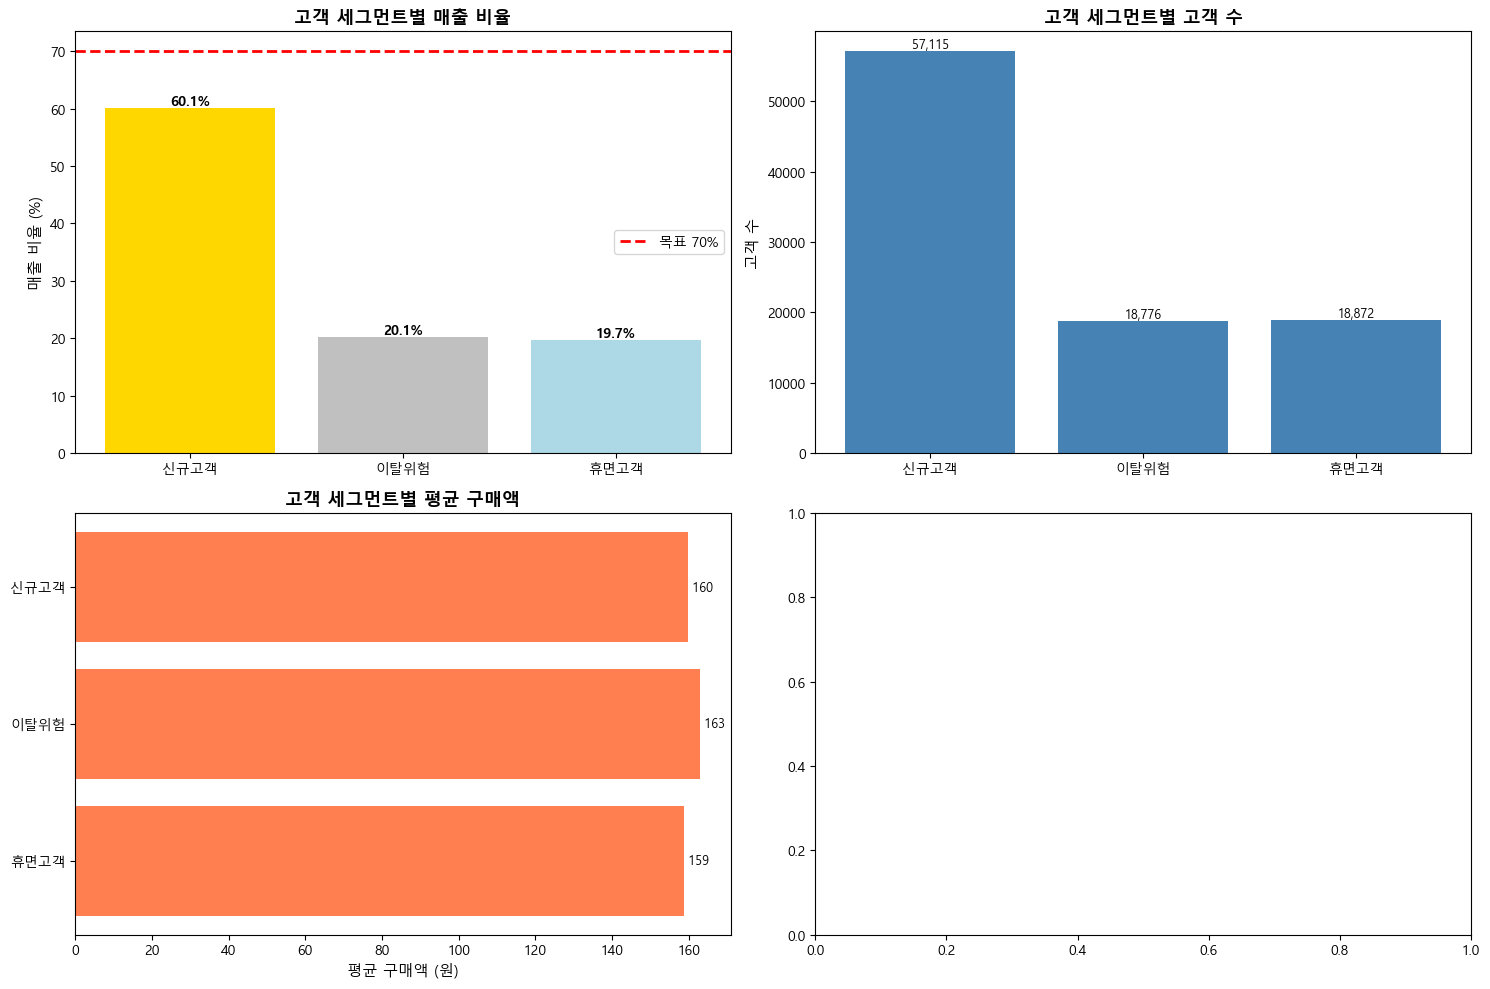

In [ ]:
# 1. 기준일 설정 
today_date = merge_oics['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 2. 고객별 RFM 집계
order_summary = merge_oics.groupby(['customer_id', 'order_id']).agg({
    'order_purchase_timestamp': 'first',
    'order_total': 'first'
}).reset_index()

# RFM 계산 
rfm = order_summary.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (today_date - x.max()).days,
    'order_id': 'nunique',
    'order_total': 'sum'
}).reset_index()

rfm.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'order_total': 'Monetary'
}, inplace=True)

# 3. RFM 점수화
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(str)

rfm['F_score'] = pd.cut(
    rfm['Frequency'],
    bins=[0, 1, 3, np.inf],
    labels=[1, 2, 3],
    right=True
).astype(str)

rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop').astype(str)

# 4. 고객 세그먼트 분류 (순서 수정!)
def segment_customer(row):
    r = int(row['R_score'])
    f = int(row['F_score'])
    m = int(row['M_score'])
    
    # 1. 우수고객: R=3-5, F=2-3, M=2-5
    if r >= 3 and f >= 2 and m >= 2:
        return '우수고객'
    
    # 2. 충성고객: R=1-2, F=3, M=2-5
    if r <= 2 and f == 3 and m >= 2:
        return '충성고객'
    
    # 3. 잠재고객: R=3-5, F=2, M=1
    if r >= 3 and f == 2 and m == 1:
        return '잠재고객'
    
    # 4. 신규고객: R=3-5, F=1
    if r >= 3 and f == 1:
        return '신규고객'
    
    # 5. 이탈위험: R=2, F=1-3, M=1-5 (위 조건에 안 걸린 R=2만)
    if r == 2:
        return '이탈위험'
    
    # 6. 휴면고객: R=1, F=1-2 (충성고객에 안 걸린 R=1만)
    if r == 1 and f <= 2:
        return '휴면고객'
    
    # 7. 일반고객 (R=1, F=3, M=1 등)
    return '일반고객'

# 세그먼트 적용
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# ============================================
# 결과 분석
# ============================================
total_revenue = rfm['Monetary'].sum()
total_customers = len(rfm)

print("=" * 90)
print("📊 고객 세그먼트별 분석")
print("=" * 90)

segment_analysis = rfm.groupby('Segment').agg({
    'customer_id': 'count',
    'Monetary': ['sum', 'mean'],
    'Recency': 'mean',
    'Frequency': 'mean'
}).round(2)

segment_analysis.columns = ['고객수', '총_매출', '평균_구매액', '평균_Recency', '평균_Frequency']
segment_analysis['고객_비율(%)'] = (segment_analysis['고객수'] / total_customers * 100).round(2)
segment_analysis['매출_비율(%)'] = (segment_analysis['총_매출'] / total_revenue * 100).round(2)
segment_analysis = segment_analysis.sort_values('총_매출', ascending=False)

for idx, row in segment_analysis.iterrows():
    print(f"{idx:12s} | 고객: {row['고객수']:>7,.0f}명 ({row['고객_비율(%)']:>5.1f}%) | "
          f"매출: {row['총_매출']:>14,.0f}원 ({row['매출_비율(%)']:>5.1f}%) | "
          f"평균: {row['평균_구매액']:>10,.0f}원")

print("\n" + "=" * 90)
print("🌟 우수고객 매출 비율 확인")
print("=" * 90)
if '우수고객' in segment_analysis.index:
    vip_ratio = segment_analysis.loc['우수고객', '매출_비율(%)']
    print(f"우수고객 매출 비율: {vip_ratio:.1f}% (목표: 70% 이상)")
    if vip_ratio >= 70:
        print(f"✅ 목표 달성! (목표보다 {vip_ratio - 70:.1f}%p 높음)")
    else:
        print(f"⚠️  목표 미달 (목표보다 {70 - vip_ratio:.1f}%p 낮음)")
else:
    print("⚠️  우수고객 세그먼트가 없습니다.")
print("=" * 90)

# 세그먼트별 RFM 점수 조합
print("\n[세그먼트별 RFM 점수 조합 (Top 5)]")
for segment in segment_analysis.index:
    print(f"\n{segment}:")
    rfm_combo = rfm[rfm['Segment']==segment][['R_score','F_score','M_score']].value_counts().head(5)
    print(rfm_combo)
    print(f"총 {len(rfm[rfm['Segment']==segment]):,}명")

# ============================================
# 시각화
# ============================================
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# (1) 세그먼트별 매출 비율
ax1 = axes[0, 0]
bars = ax1.bar(segment_analysis.index, segment_analysis['매출_비율(%)'], 
               color=['gold', 'silver', 'lightblue', 'lightgreen', 'orange', 'lightcoral', 'gray'])
ax1.set_ylabel('매출 비율 (%)', fontsize=11)
ax1.set_title('고객 세그먼트별 매출 비율', fontsize=13, fontweight='bold')
ax1.axhline(y=70, color='red', linestyle='--', linewidth=2, label='목표 70%')
ax1.legend()
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# (2) 세그먼트별 고객 수
ax2 = axes[0, 1]
ax2.bar(segment_analysis.index, segment_analysis['고객수'], color='steelblue')
ax2.set_ylabel('고객 수', fontsize=11)
ax2.set_title('고객 세그먼트별 고객 수', fontsize=13, fontweight='bold')
for i, (idx, row) in enumerate(segment_analysis.iterrows()):
    ax2.text(i, row['고객수'], f"{row['고객수']:,.0f}", 
             ha='center', va='bottom', fontsize=9)

# (3) 세그먼트별 평균 구매액
ax3 = axes[1, 0]
ax3.barh(segment_analysis.index, segment_analysis['평균_구매액'], color='coral')
ax3.set_xlabel('평균 구매액 (원)', fontsize=11)
ax3.set_title('고객 세그먼트별 평균 구매액', fontsize=13, fontweight='bold')
ax3.invert_yaxis()
for i, (idx, row) in enumerate(segment_analysis.iterrows()):
    ax3.text(row['평균_구매액'], i, f" {row['평균_구매액']:,.0f}", 
             va='center', fontsize=9)

# (4) 우수고객 비율 파이차트
ax4 = axes[1, 1]
if '우수고객' in segment_analysis.index:
    vip_revenue = segment_analysis.loc['우수고객', '총_매출']
    other_revenue = total_revenue - vip_revenue
    colors = ['gold', 'lightgray']
    wedges, texts, autotexts = ax4.pie([vip_revenue, other_revenue], 
                                         labels=['우수고객', '기타'],
                                         autopct='%1.1f%%',
                                         colors=colors, 
                                         startangle=90,
                                         textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax4.set_title('우수고객 vs 기타 매출 비율', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [59]:

# ============================================
# 데이터 분포 확인
# ============================================
print("=" * 70)
print("📊 RFM 점수 분포 확인")
print("=" * 70)

print("\n[R_score 분포]")
print(rfm['R_score'].value_counts().sort_index())

print("\n[F_score 분포]")
f_dist = rfm['F_score'].value_counts().sort_index()
print(f_dist)
print(f"\nF=1: {f_dist.get('1', 0):,}명 ({f_dist.get('1', 0)/len(rfm)*100:.1f}%)")
print(f"F=2: {f_dist.get('2', 0):,}명 ({f_dist.get('2', 0)/len(rfm)*100:.1f}%)")
print(f"F=3: {f_dist.get('3', 0):,}명 ({f_dist.get('3', 0)/len(rfm)*100:.1f}%)")

print("\n[M_score 분포]")
print(rfm['M_score'].value_counts().sort_index())

# 우수고객 조건에 맞는 고객 수 확인
print("\n" + "=" * 70)
print("🔍 우수고객 조건 분석 (R>=3, F>=2, M>=2)")
print("=" * 70)

r_condition = rfm['R_score'].astype(int) >= 3
f_condition = rfm['F_score'].astype(int) >= 2
m_condition = rfm['M_score'].astype(int) >= 2

print(f"R>=3인 고객: {r_condition.sum():,}명 ({r_condition.sum()/len(rfm)*100:.1f}%)")
print(f"F>=2인 고객: {f_condition.sum():,}명 ({f_condition.sum()/len(rfm)*100:.1f}%)")
print(f"M>=2인 고객: {m_condition.sum():,}명 ({m_condition.sum()/len(rfm)*100:.1f}%)")
print(f"R>=3 AND F>=2인 고객: {(r_condition & f_condition).sum():,}명")
print(f"R>=3 AND F>=2 AND M>=2인 고객 (우수고객): {(r_condition & f_condition & m_condition).sum():,}명")

# F>=2인 고객의 상세 분포
print("\n[F>=2 고객의 R, M 분포]")
f2_customers = rfm[rfm['F_score'].astype(int) >= 2]
if len(f2_customers) > 0:
    print(f"총 {len(f2_customers):,}명")
    print("\nR_score 분포:")
    print(f2_customers['R_score'].value_counts().sort_index())
    print("\nM_score 분포:")
    print(f2_customers['M_score'].value_counts().sort_index())
else:
    print("F>=2인 고객이 없습니다!")


📊 RFM 점수 분포 확인

[R_score 분포]
R_score
1    18872
2    18776
3    19040
4    19054
5    19021
Name: count, dtype: int64

[F_score 분포]
F_score
1    94763
Name: count, dtype: int64

F=1: 94,763명 (100.0%)
F=2: 0명 (0.0%)
F=3: 0명 (0.0%)

[M_score 분포]
M_score
1    18964
2    18943
3    18953
4    18951
5    18952
Name: count, dtype: int64

🔍 우수고객 조건 분석 (R>=3, F>=2, M>=2)
R>=3인 고객: 57,115명 (60.3%)
F>=2인 고객: 0명 (0.0%)
M>=2인 고객: 75,799명 (80.0%)
R>=3 AND F>=2인 고객: 0명
R>=3 AND F>=2 AND M>=2인 고객 (우수고객): 0명

[F>=2 고객의 R, M 분포]
F>=2인 고객이 없습니다!


In [ ]:
# RFM 계산 
rfm = order_summary.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (today_date - x.max()).days,  # Recency
    'order_id': 'nunique',                                               # Frequency
    'order_total': 'sum'                                                 # Monetary
}).reset_index()

In [ ]:
# 1. 기준일 설정 
today_date = merge_oics['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 2. 고객별 RFM 집계
order_summary = merge_oics.groupby(['customer_id', 'order_id']).agg({
    'order_purchase_timestamp': 'first',
    'order_total': 'first'
}).reset_index()

# RFM 계산 
rfm = order_summary.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (today_date - x.max()).days,  # Recency
    'order_id': 'nunique',                                               # Frequency
    'order_total': 'sum'                                                 # Monetary
}).reset_index()

rfm.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'order_total': 'Monetary'
}, inplace=True)

# 3. RFM 점수화
# Recency 
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(str)

# Frequency 
rfm['F_score'] = pd.cut(
    rfm['Frequency'],
    bins=[0, 1, 3, np.inf],     # (0~1] / (1~3] / (3~∞]
    labels=[1, 2, 3],            # 1=일회성, 2=재구매, 3=충성
    right=True
).astype(str)

# Monetary 
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop').astype(str)

# 4. 고객 세그먼트 분류
def segment_customer(row):
    r = int(row['R_score'])
    f = int(row['F_score'])
    m = int(row['M_score'])
    
    if r >= 4 and f == 3 and m >= 4:
        return 'VIP 우수고객'
    
    if r == 5 and f == 1 and m >= 4:
        return '신규 고객 (고가치)'
    
    if r >= 4 and f == 2:
        if m >= 4:
            return '잠재 충성 고객 (고가치)'
        return '잠재 충성 고객'
    
    if r == 2 and f >= 2 and m >= 4:
        return '이탈 위험 (VIP)'
    
    if r == 1 and f == 3 and m >= 4:
        return '휴면 고객 (VIP 복귀 대상)'
    
    if r == 1 and f == 1 and m <= 2:
        return '휴면 고객 (포기)'
    
    return '일반 고객'

# 세그먼트 적용
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# 결과 확인
print("[세그먼트별 고객 수]")
print(rfm['Segment'].value_counts())

print("\n[세그먼트별 평균 RFM]")
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_id': 'count'
}).round(2)
segment_summary.columns = ['평균_Recency(일)', '평균_구매횟수', '평균_금액', '고객수']
print(segment_summary.sort_values('평균_금액', ascending=False))

# 주요 세그먼트의 RFM 점수 조합 확인
print("\n[주요 세그먼트의 RFM 점수 조합]")
key_segments = ['핵심 VIP', '신규 고객 (고가치)', '잠재 충성 고객', 
                '이탈 위험 (VIP)', '휴면 고객 (VIP 복귀 대상)', '휴면 고객 (포기)']

for segment in key_segments:
    if segment in rfm['Segment'].values:
        print(f"\n{segment}:")
        rfm_combo = rfm[rfm['Segment']==segment][['R_score','F_score','M_score']].value_counts().head(3)
        print(rfm_combo)
        print(f"총 {len(rfm[rfm['Segment']==segment])}명")

[세그먼트별 고객 수]
Segment
일반 고객          79045
휴면 고객 (포기)      7908
신규 고객 (고가치)     7810
Name: count, dtype: int64

[세그먼트별 평균 RFM]
             평균_Recency(일)  평균_구매횟수   평균_금액    고객수
Segment                                           
신규 고객 (고가치)          48.61      1.0  297.04   7810
일반 고객               238.11      1.0  157.17  79045
휴면 고객 (포기)          476.33      1.0   54.23   7908

[주요 세그먼트의 RFM 점수 조합]

신규 고객 (고가치):
R_score  F_score  M_score
5        1        4          3919
                  5          3891
Name: count, dtype: int64
총 7810명

휴면 고객 (포기):
R_score  F_score  M_score
1        1        1          3963
                  2          3945
Name: count, dtype: int64
총 7908명


📊 전체 매출 대비 고객 등급별 매출 비율 (%)
일반 고객                     :  81.88% (매출:   12,423,786원, 79,045명)
신규 고객 (고가치)               :  15.29% (매출:    2,319,908원,  7,810명)
휴면 고객 (포기)                :   2.83% (매출:      428,871원,  7,908명)

💰 고객 등급별 평균 구매액
신규 고객 (고가치)               :     297.04원
일반 고객                     :     157.17원
휴면 고객 (포기)                :      54.23원

🌟 VIP 고객 (상위 20% 지출) 현황
VIP 고객 수       :     18,955명 / 전체     94,763명 ( 20.0%)
VIP 매출          :       8,082,556.61원
전체 매출         :      15,172,565.38원
VIP 매출 비율     :  53.3%
VIP 평균 구매액   :             426.41원
Non-VIP 평균 구매액:              93.53원


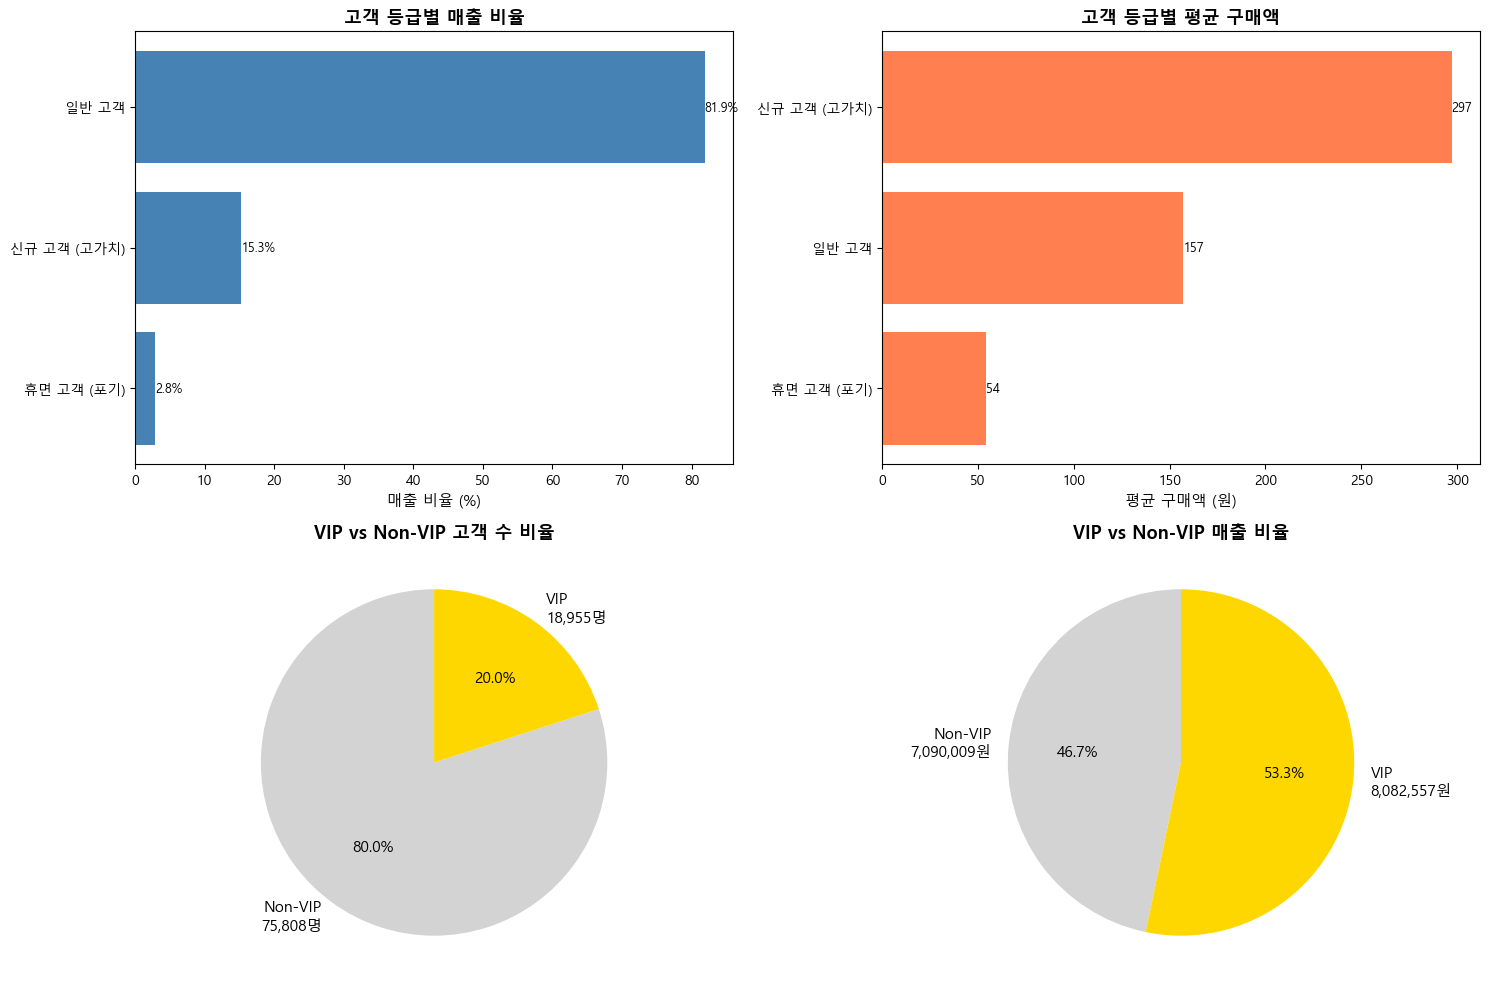


💡 핵심 인사이트
1. VIP 고객(상위 20%)이 전체 고객의 20.0%이지만, 전체 매출의 53.3% 차지
2. VIP 평균 구매액(426원)은 Non-VIP(94원)의 4.6배
3. 가장 높은 매출 비율: 일반 고객 (81.9%)
4. 가장 높은 평균 구매액: 신규 고객 (고가치) (297원)


In [53]:
# ============================================
# 1. 전체 매출 대비 고객 등급별 매출 비율
# ============================================
total_revenue = rfm['Monetary'].sum()

segment_revenue = rfm.groupby('Segment').agg({
    'Monetary': ['sum', 'mean', 'count']
}).round(2)
segment_revenue.columns = ['총_매출', '평균_구매액', '고객수']
segment_revenue['매출_비율(%)'] = (segment_revenue['총_매출'] / total_revenue * 100).round(2)
segment_revenue = segment_revenue.sort_values('총_매출', ascending=False)

print("=" * 70)
print("📊 전체 매출 대비 고객 등급별 매출 비율 (%)")
print("=" * 70)
for idx, row in segment_revenue.iterrows():
    print(f"{idx:25s} : {row['매출_비율(%)']:6.2f}% (매출: {row['총_매출']:>12,.0f}원, {row['고객수']:>6,.0f}명)")

# ============================================
# 2. 고객 등급별 평균 구매액
# ============================================
print("\n" + "=" * 70)
print("💰 고객 등급별 평균 구매액")
print("=" * 70)
segment_avg = segment_revenue.sort_values('평균_구매액', ascending=False)
for idx, row in segment_avg.iterrows():
    print(f"{idx:25s} : {row['평균_구매액']:>10,.2f}원")

# ============================================
# 3. VIP 고객 (상위 20% 지출) 현황
# ============================================
vip_threshold = rfm['Monetary'].quantile(0.8)
rfm['VIP_여부'] = rfm['Monetary'] >= vip_threshold

vip_count = (rfm['VIP_여부'] == True).sum()
total_count = len(rfm)
vip_revenue = rfm[rfm['VIP_여부'] == True]['Monetary'].sum()

print("\n" + "=" * 70)
print("🌟 VIP 고객 (상위 20% 지출) 현황")
print("=" * 70)
print(f"VIP 고객 수       : {vip_count:>10,}명 / 전체 {total_count:>10,}명 ({vip_count/total_count*100:>5.1f}%)")
print(f"VIP 매출          : {vip_revenue:>18,.2f}원")
print(f"전체 매출         : {total_revenue:>18,.2f}원")
print(f"VIP 매출 비율     : {vip_revenue/total_revenue*100:>5.1f}%")
print(f"VIP 평균 구매액   : {vip_revenue/vip_count:>18,.2f}원")
print(f"Non-VIP 평균 구매액: {rfm[rfm['VIP_여부'] == False]['Monetary'].mean():>18,.2f}원")
print("=" * 70)

# ============================================
# 4. 시각화
# ============================================
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# (1) 세그먼트별 매출 비율
ax1 = axes[0, 0]
top_segments = segment_revenue.head(10)
bars = ax1.barh(top_segments.index, top_segments['매출_비율(%)'], color='steelblue')
ax1.set_xlabel('매출 비율 (%)', fontsize=11)
ax1.set_title('고객 등급별 매출 비율', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
             ha='left', va='center', fontsize=9)

# (2) 세그먼트별 평균 구매액
ax2 = axes[0, 1]
top_avg = segment_revenue.sort_values('평균_구매액', ascending=False).head(10)
bars = ax2.barh(top_avg.index, top_avg['평균_구매액'], color='coral')
ax2.set_xlabel('평균 구매액 (원)', fontsize=11)
ax2.set_title('고객 등급별 평균 구매액', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f}', 
             ha='left', va='center', fontsize=9)

# (3) VIP vs Non-VIP 고객 수
ax3 = axes[1, 0]
vip_data = [total_count - vip_count, vip_count]
labels = [f'Non-VIP\n{total_count - vip_count:,}명', f'VIP\n{vip_count:,}명']
colors = ['lightgray', 'gold']
wedges, texts, autotexts = ax3.pie(vip_data, labels=labels, autopct='%1.1f%%',
                                     colors=colors, startangle=90, textprops={'fontsize': 11})
ax3.set_title('VIP vs Non-VIP 고객 수 비율', fontsize=13, fontweight='bold')

# (4) VIP vs Non-VIP 매출
ax4 = axes[1, 1]
revenue_data = [total_revenue - vip_revenue, vip_revenue]
labels = [f'Non-VIP\n{total_revenue - vip_revenue:,.0f}원', f'VIP\n{vip_revenue:,.0f}원']
wedges, texts, autotexts = ax4.pie(revenue_data, labels=labels, autopct='%1.1f%%',
                                     colors=colors, startangle=90, textprops={'fontsize': 11})
ax4.set_title('VIP vs Non-VIP 매출 비율', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================
# 5. 핵심 인사이트
# ============================================
print("\n" + "=" * 70)
print("💡 핵심 인사이트")
print("=" * 70)
print(f"1. VIP 고객(상위 20%)이 전체 고객의 {vip_count/total_count*100:.1f}%이지만, "
      f"전체 매출의 {vip_revenue/total_revenue*100:.1f}% 차지")
print(f"2. VIP 평균 구매액({vip_revenue/vip_count:,.0f}원)은 "
      f"Non-VIP({rfm[rfm['VIP_여부'] == False]['Monetary'].mean():,.0f}원)의 "
      f"{(vip_revenue/vip_count) / rfm[rfm['VIP_여부'] == False]['Monetary'].mean():.1f}배")
print(f"3. 가장 높은 매출 비율: {segment_revenue.index[0]} ({segment_revenue.iloc[0]['매출_비율(%)']:.1f}%)")
print(f"4. 가장 높은 평균 구매액: {segment_avg.index[0]} ({segment_avg.iloc[0]['평균_구매액']:,.0f}원)")
print("=" * 70)

=== 전체 매출 대비 고객 등급별 매출 비율 (%) ===
Segment
잠재 충성 고객    59.91
이탈 고객       40.09
Name: Monetary, dtype: float64

=== 고객 등급별 평균 구매액 ===
Segment
이탈 고객       138.50
잠재 충성 고객    136.44
Name: Monetary, dtype: float64
=== VIP 고객 (상위 20% 지출) 현황 ===
VIP 고객 수: 18955 / 전체 고객 수: 94763 (20.00%)
VIP 매출: 7,346,912.58 / 전체 매출: 13,007,155.02 (56.48%)


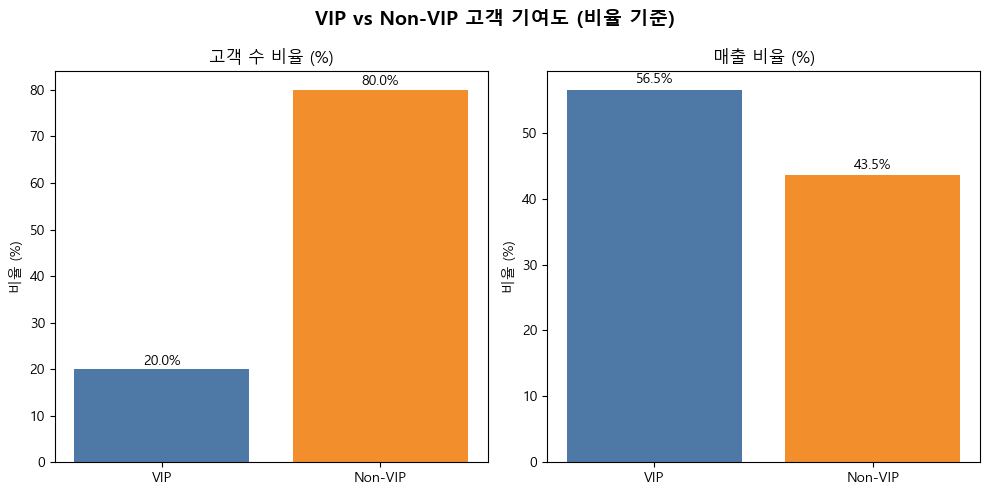

In [ ]:
## 1. 전체 매출 대비 고객 등급별 매출 비율
segment_sales = (
    rfm.groupby('Segment')['Monetary']
    .sum()
    .sort_values(ascending=False)
)
total_sales = segment_sales.sum()
segment_sales_ratio = (segment_sales / total_sales) * 100

print("=== 전체 매출 대비 고객 등급별 매출 비율 (%) ===")
print(segment_sales_ratio.round(2))

## 2. 고객 등급별 평균 구매액
segment_avg_purchase = (
    rfm.groupby('Segment')['Monetary']
    .mean()
    .sort_values(ascending=False)
)
print("\n=== 고객 등급별 평균 구매액 ===")
print(segment_avg_purchase.round(2))

##3. VIP고객 매출액 비율
# VIP 기준: 상위 20% 지출 고객
threshold = rfm['Monetary'].quantile(0.80)
rfm['is_VIP'] = (rfm['Monetary'] >= threshold).astype(int)
vip_customers = rfm[rfm['is_VIP'] == 1]
vip_count = vip_customers.shape[0]
total_count = rfm.shape[0]

vip_sales = vip_customers['Monetary'].sum()
total_sales = rfm['Monetary'].sum()

print("=== VIP 고객 (상위 20% 지출) 현황 ===")
print(f"VIP 고객 수: {vip_count} / 전체 고객 수: {total_count} ({vip_count/total_count*100:.2f}%)")
print(f"VIP 매출: {vip_sales:,.2f} / 전체 매출: {total_sales:,.2f} ({vip_sales/total_sales*100:.2f}%)")

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False 
# VIP / Non-VIP 데이터
vip_count = rfm[rfm['is_VIP'] == 1].shape[0]
nonvip_count = rfm[rfm['is_VIP'] == 0].shape[0]

vip_sales = rfm.loc[rfm['is_VIP'] == 1, 'Monetary'].sum()
nonvip_sales = rfm.loc[rfm['is_VIP'] == 0, 'Monetary'].sum()

# 비율 계산
count_ratio = [vip_count / (vip_count + nonvip_count) * 100,
               nonvip_count / (vip_count + nonvip_count) * 100]
sales_ratio = [vip_sales / (vip_sales + nonvip_sales) * 100,
               nonvip_sales / (vip_sales + nonvip_sales) * 100]

labels = ['VIP', 'Non-VIP']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 고객 수 비율
axes[0].bar(labels, count_ratio, color=['#4e79a7', '#f28e2b'])
axes[0].set_title("고객 수 비율 (%)")
axes[0].set_ylabel("비율 (%)")
for i, v in enumerate(count_ratio):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha='center')

# 매출 비율
axes[1].bar(labels, sales_ratio, color=['#4e79a7', '#f28e2b'])
axes[1].set_title("매출 비율 (%)")
axes[1].set_ylabel("비율 (%)")
for i, v in enumerate(sales_ratio):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center')

plt.suptitle("VIP vs Non-VIP 고객 기여도 (비율 기준)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

customer_state
SP    4987136.84
RJ    1732510.16
MG    1527245.94
RS     717306.08
PR     653243.44
SC     499708.95
BA     486482.20
DF     289166.64
GO     276146.36
ES     263401.96
PE     249328.92
CE     214270.45
PA     173501.74
MT     148691.62
MA     115754.66
MS     113985.82
PB     110107.93
PI      83664.52
RN      81031.97
AL      77959.14
SE      55616.39
TO      47892.33
RO      45412.76
AM      22079.84
AC      15524.98
AP      13274.91
RR       6708.47
Name: price, dtype: float64
customer_state
SP    38.34
RJ    13.32
MG    11.74
RS     5.51
PR     5.02
SC     3.84
BA     3.74
DF     2.22
GO     2.12
ES     2.03
PE     1.92
CE     1.65
PA     1.33
MT     1.14
MA     0.89
MS     0.88
PB     0.85
PI     0.64
RN     0.62
AL     0.60
SE     0.43
TO     0.37
RO     0.35
AM     0.17
AC     0.12
AP     0.10
RR     0.05
Name: price, dtype: float64


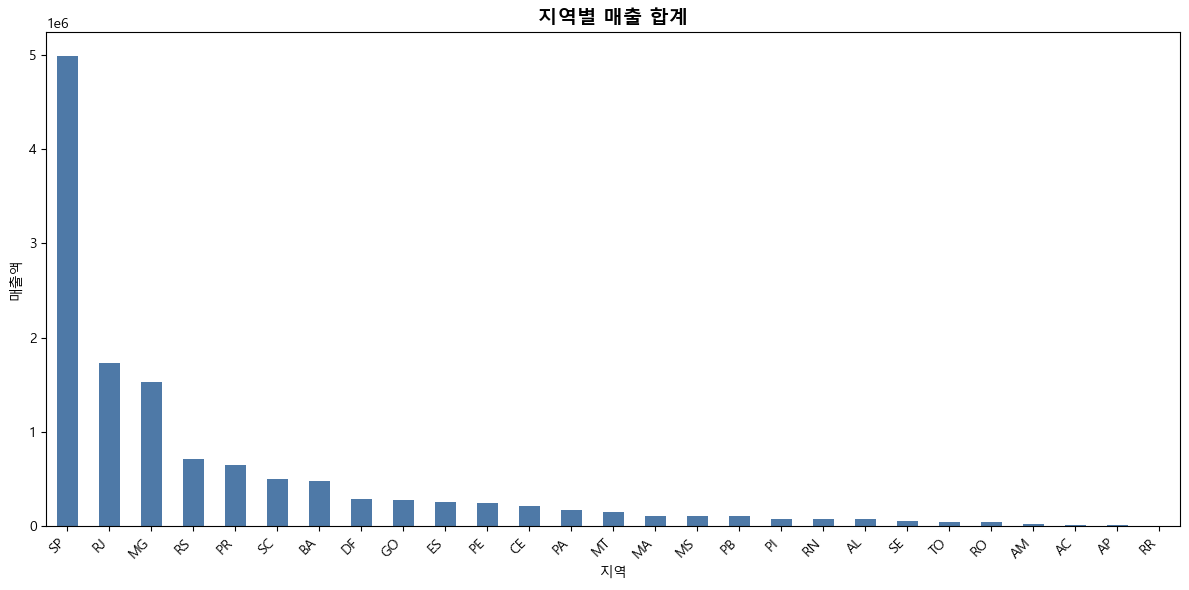

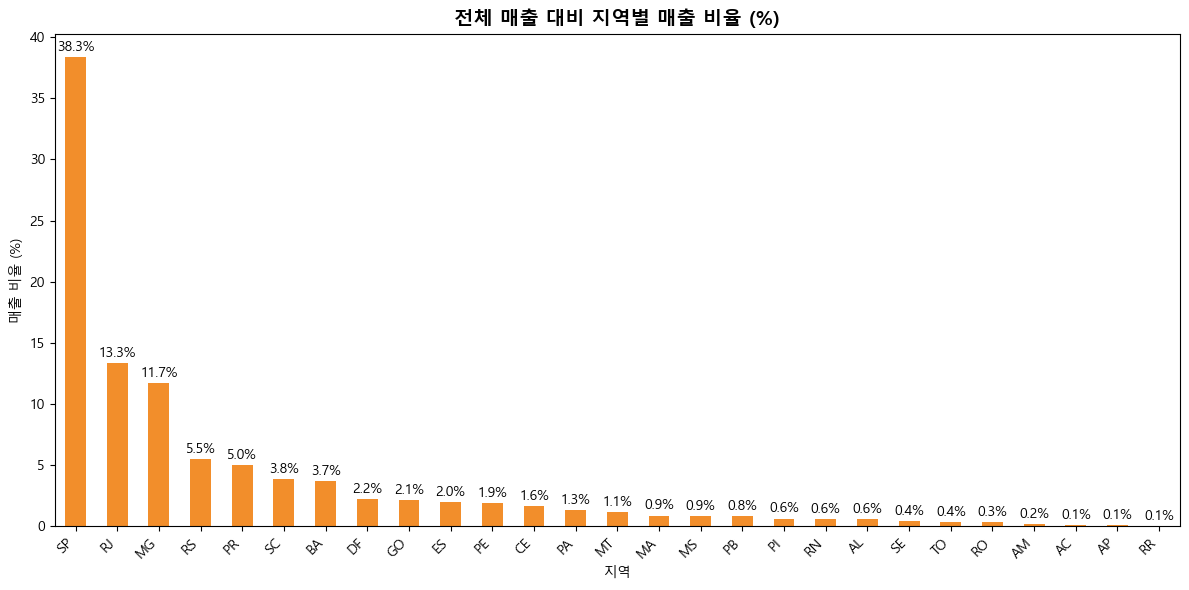

In [ ]:
# 3. 지역별 매출 합계
region_sales = (
    merge_oics.groupby('customer_state')['price']
    .sum()
    .sort_values(ascending=False)
)
print(region_sales.round(2))

# 4. 전체 매출 대비 지역별 매출 비율
region_sales_ratio = (region_sales / region_sales.sum()) * 100
print(region_sales_ratio.round(2))

import matplotlib.pyplot as plt

# 시각화
# 1) 지역별 매출 합계 바그래프
plt.figure(figsize=(12,6))
region_sales.plot(kind='bar', color='#4e79a7')
plt.title("지역별 매출 합계", fontsize=14, fontweight='bold')
plt.xlabel("지역")
plt.ylabel("매출액")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2) 지역별 매출 비율 바그래프
plt.figure(figsize=(12,6))
region_sales_ratio.plot(kind='bar', color='#f28e2b')
plt.title("전체 매출 대비 지역별 매출 비율 (%)", fontsize=14, fontweight='bold')
plt.xlabel("지역")
plt.ylabel("매출 비율 (%)")
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(region_sales_ratio):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()
